In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
mass = 0.05
mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1652886022778008e-16


In [ ]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=100,max_levels=2)

self.dof_list:[12, 12, 12, 12, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x8
self.grid_list:[[8, 8, 8, 8]]


In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 3.35 ms, sys: 418 μs, total: 3.77 ms
Wall time: 20.6 ms
CPU times: user 1.1 ms, sys: 137 μs, total: 1.24 ms
Wall time: 1.21 ms
221.70250336881628
10.62561944948037
248.38478708613687
248.38478708613687
1.7505229586402284e-16
CPU times: user 6.94 ms, sys: 864 μs, total: 7.8 ms
Wall time: 24.5 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 6.17 ms, sys: 0 ns, total: 6.17 ms
Wall time: 5.09 ms
CPU times: user 1.26 ms, sys: 0 ns, total: 1.26 ms
Wall time: 1.2 ms


In [7]:
# b0 = mg.b_list[0]
# b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
# _b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
# _b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
# print(_b1.flatten()[:100]/b1.flatten()[:100])

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:221.3797633073902
Norm of r:334.6221023775494
Norm of x0:222.09112893478067
BICGSTAB-Iteration 0: Residual = 7.178554e+01, Time = 0.005378 s
BICGSTAB-Iteration 1: Residual = 3.155911e+01, Time = 0.002892 s
BICGSTAB-Iteration 2: Residual = 3.141660e+01, Time = 0.003220 s
BICGSTAB-Iteration 3: Residual = 2.030351e+01, Time = 0.003124 s
BICGSTAB-Iteration 4: Residual = 1.264354e+01, Time = 0.005502 s
BICGSTAB-Iteration 5: Residual = 1.587883e+01, Time = 0.004695 s
BICGSTAB-Iteration 6: Residual = 7.264899e+00, Time = 0.004622 s
BICGSTAB-Iteration 7: Residual = 5.471070e+00, Time = 0.003766 s
BICGSTAB-Iteration 8: Residual = 1.345958e+01, Time = 0.002952 s
BICGSTAB-Iteration 9: Residual = 3.986343e+00, Time = 0.003484 s
BICGSTAB-Iteration 10: Residual = 4.821581e+00, Time = 0.003732 s
BICGSTAB-Iteration 11: Residual = 4.500271e+00, Time = 0.003449 s
BICGSTAB-Iteration 12: Residual = 6.530433e+01, Time = 0.003459 s
BICGSTAB-Iteration 13: Residual = 1.249997e+01, Time = 0.003273 s


Norm of b:221.3797633073902
Norm of r:334.37554553826436
Norm of x0:222.05283536782224
MG-0-BICGSTAB-Iteration 0: Residual = 7.199537e+01, Time = 0.058398 s
MG-0-BICGSTAB-Iteration 1: Residual = 3.083126e+01, Time = 0.004079 s
MG-0-BICGSTAB-Iteration 2: Residual = 3.197827e+01, Time = 0.004164 s
MG-0-BICGSTAB-Iteration 3: Residual = 2.066566e+01, Time = 0.006820 s
MG-0-BICGSTAB-Iteration 4: Residual = 1.285354e+01, Time = 0.003298 s
MG-0-BICGSTAB-Iteration 5: Residual = 1.039956e+01, Time = 0.002933 s
MG-0-BICGSTAB-Iteration 6: Residual = 8.353865e+00, Time = 0.003649 s
MG-0-BICGSTAB-Iteration 7: Residual = 1.714148e+01, Time = 0.002964 s
MG-0-BICGSTAB-Iteration 8: Residual = 9.317746e+00, Time = 0.002907 s
MG-0-BICGSTAB-Iteration 9: Residual = 7.118081e+00, Time = 0.002807 s
MG-0-BICGSTAB-Iteration 10: Residual = 5.300559e+00, Time = 0.002771 s
MG-0-BICGSTAB-Iteration 11: Residual = 5.576424e+00, Time = 0.002747 s
MG-0-BICGSTAB-Iteration 12: Residual = 6.610933e+00, Time = 0.002745 s


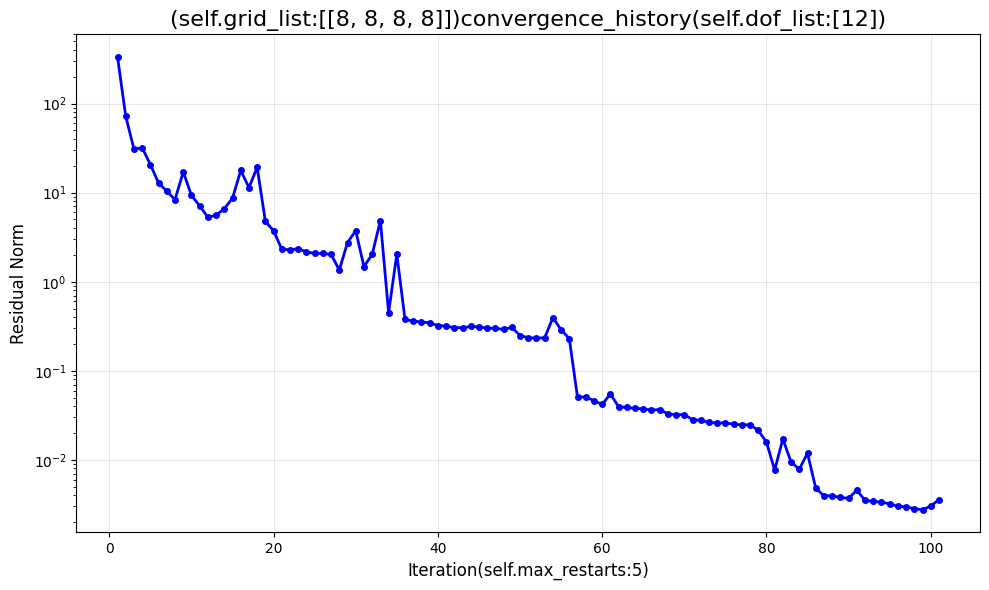

In [9]:
x = mg.solve()
mg.plot()

In [10]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([-1.1602e-05+8.6705e-06j, -9.5955e-06+8.7777e-06j, -1.0374e-05+8.1255e-06j,
        -7.4329e-06+8.5894e-06j, -7.5642e-06+8.5364e-06j, -5.2827e-06+6.7923e-06j,
        -8.8707e-06+9.7959e-06j, -5.1372e-06+8.1020e-06j, -8.7857e-06+9.8996e-06j,
        -1.7445e-05+9.5800e-06j, -1.1264e-05+9.8706e-06j, -9.5495e-06+6.2172e-06j,
        -5.6694e-06+7.5149e-06j, -1.0550e-05+8.5299e-06j, -4.3088e-06+6.4576e-06j,
        -1.1774e-05+8.9907e-06j, -1.1681e-05+1.1377e-05j, -9.2404e-06+9.1695e-06j,
        -1.1811e-05+8.5227e-06j, -1.0093e-05+9.6794e-06j, -1.0235e-05+8.2976e-06j,
        -6.0404e-06+9.0996e-06j, -8.7249e-06+6.6359e-06j, -6.8538e-06+9.1638e-06j,
        -7.2946e-06+5.8566e-06j, -1.2153e-05+5.5145e-06j, -7.3471e-06+8.3855e-06j,
        -1.1411e-05+4.5586e-06j, -7.0959e-06+9.0126e-06j, -7.9673e-06+7.3614e-06j,
        -6.7914e-06+7.3133e-06j, -1.1345e-05+7.9481e-06j, -9.0485e-06+6.4624e-06j,
        -8.4604e-06+6.7661e-06j, -5.6242e-06+6.6734e-06j, -5.2587e-06+6.4128e-06j,
    

In [11]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

0.0009789093062033613


In [12]:
mg.num_levels

1

In [13]:
index = -1
mg.u_list[-1] = inverse.bicgstab(b=torch.ones_like(mg.b_list[-1]),
                                 matvec=mg.op_list[-1].matvec, verbose=verbose,max_iter=10000)

Norm of b:221.70250336881628
Norm of r:333.16807356074645
Norm of x0:221.451346053286
BICGSTAB-Iteration 0: Residual = 2.329600e+02, Time = 0.008419 s
BICGSTAB-Iteration 1: Residual = 1.787446e+03, Time = 0.005565 s
BICGSTAB-Iteration 2: Residual = 1.145856e+03, Time = 0.003694 s
BICGSTAB-Iteration 3: Residual = 7.163388e+02, Time = 0.006084 s
BICGSTAB-Iteration 4: Residual = 3.072688e+02, Time = 0.006448 s
BICGSTAB-Iteration 5: Residual = 1.962980e+02, Time = 0.003001 s
BICGSTAB-Iteration 6: Residual = 1.719798e+02, Time = 0.004010 s
BICGSTAB-Iteration 7: Residual = 1.222064e+02, Time = 0.003962 s
BICGSTAB-Iteration 8: Residual = 1.124191e+02, Time = 0.005647 s
BICGSTAB-Iteration 9: Residual = 1.019038e+02, Time = 0.005083 s
BICGSTAB-Iteration 10: Residual = 8.384537e+01, Time = 0.003261 s
BICGSTAB-Iteration 11: Residual = 6.490974e+01, Time = 0.003593 s
BICGSTAB-Iteration 12: Residual = 7.940376e+01, Time = 0.003539 s
BICGSTAB-Iteration 13: Residual = 6.959360e+01, Time = 0.003660 s
